In [382]:
import glob
import os
import pandas as pd
import numpy as np

##################### Traces description
# 1. CLT_PUSH_START - SENDING           Time between the scheduling of the request and its actual processing
# 2. CLT_PUSH_END - CLT_PUSH_START      Time to prepare the packet, send it to the NIC driver through rte_eth_tx_burst(), and free the dpdk mbuf
# 3. SRV_POP_START - CLT_PUSH_END       Time on the wire: item detected in the io queue's receive queue - client packet sent /!\ I think this can be negative if the server schedule's pop way before the client sends requests
# 4. SRV_POP_END - SRV_POP_START        Time to parse incoming packet + "waiting time" at the server's queue
# 5. NET_RECEIVE - SRV_POP_END          Time between message delivered to the application by dmtr_wait_any() and packet processed by the I/O queue
# 6. HTTP_DISPATCH - NET_RECEIVE        Time taken to select the HTTP recipient (either RR, or apply the filter, etc)
# 7. START_HTTP - HTTP_DISPATCH         Time spent in memory queue between network component and HTTP
# 8. END_HTTP - START_HTTP              Time spent performing HTTP processing
# 9. HTTP_DONE - END_HTTP               Time spent in memory queue between HTTP component and HTPP /!\ This include the "wait time" of dmtr_wait_any, as the same poll operates on both network sockets, and this memory queue
# 10. SRV_PUSH_START - HTTP_DONE        Time between the scheduling of the response and its actual processing
# 11. SRV_PUSH_END - SRV_PUSH_START     Time spent preparing the packet and sending it to the wire (identical to #2)
# 12. CLT_POP_START - SRV_PUSH_END      Time spent on the wire /!\ I think this can be negative as the client schedules the read as soon as it as sent the request
# 13. CLT_POP_END - CLT_POP_START       Time spent processing an incoming network packet (includes wait time) (identical to #4)
# 14. COMPLETED - CLT_POP_END           Time ellapsed between the reponse being delivered to the client by dmtr_wait_any(), and the response's being fully processed by the I/O queue

TRACE_ORDER = [
    'SENDING',
    'CLT_PUSH_START',
#     'CLT_PUSH_END',
#     'SRV_POP_START',
    'SRV_POP_END',
    'NET_RECEIVE',
    'HTTP_DISPATCH',
    'START_HTTP',
    'END_HTTP',
    'HTTP_DONE',
    'SRV_PUSH_START',
#     'SRV_PUSH_END',
#     'CLT_POP_START',
    'CLT_POP_END',
    'COMPLETED'
]

def read_tokens(trace_dir, exclude_first = 5):
    #REQ_ID	SENDING	READING	COMPLETED	PUSH_TOKEN	POP_TOKEN)
    files = glob.glob(os.path.join(trace_dir, '*traces*'))
    files = list(filter(lambda x: not ('POP' in x or 'PUSH' in x), files))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    
    min_time = df[df.columns[1]].min()
    df = df[df[df.columns[1]] > min_time + exclude_first * 1e9]
    return df

def read_traces(trace_dir, label):
    files = glob.glob(os.path.join(trace_dir, '*%s-traces' % label))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    return df

def merge_trace(token_df, trace_df, token_label, col_label):
    trace_df = trace_df[['%s_TOKEN' % token_label, 'TIME']]
    df = pd.merge(token_df, trace_df, on='%s_TOKEN' % token_label)
#     return df
    return df.rename(columns={'TIME': col_label})

def merge_traces(token_df, trace_df, token_label, col_label):
    start_df = trace_df[trace_df.START]
    stop_df = trace_df[~trace_df.START]

    df = merge_trace(token_df, start_df, token_label, '%s_%s_START' % (col_label, token_label))
    df = merge_trace(df, stop_df, token_label, '%s_%s_END' % (col_label, token_label))
    return df

col_labels = dict(client='CLT', server='SRV')
token_labels = dict(client='rate_client', server='')

def order_cols(df, subtract_root = True):
    col_order = list(filter(lambda x: x in df.columns, TRACE_ORDER, ))
    df = df[['REQ_ID'] +col_order].set_index('REQ_ID')
    
    if subtract_root:
        df[col_order] = df[col_order].apply(lambda x: x - df[col_order[0]])
    return df

def read_profiling_node(base_dir, experiment, node_label):
    client_dir = os.path.join(base_dir, experiment, node_label)
    token_df = read_tokens(client_dir)
    push_df = read_traces(client_dir, 'PUSH')
    pop_df = read_traces(client_dir, 'POP')
    
    df = merge_traces(token_df, push_df, 'PUSH', col_labels[node_label])
    df = merge_traces(df, pop_df, 'POP', col_labels[node_label])
    
    return order_cols(df)
    
CLIENT_RCV = 'CLT_POP_END'
CLIENT_SND = 'CLT_PUSH_START'
    
def read_merged_profiling(base_dir, experiment):
    client_df = read_profiling_node(base_dir, experiment, 'client')
    server_df = read_profiling_node(base_dir, experiment, 'server')
    
    server_cols = server_df.columns
    client_cols = client_df.columns
    
    df = client_df.join(server_df)
    
    offset = df[CLIENT_SND]
    
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    
    offset =( df[CLIENT_RCV] - df[server_cols[-1]]) / 2
    
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    
    
    return order_cols(df.reset_index())

In [419]:
COLORS = ["#700f00",
"#013fb0",
"#cbcd11",
"#6b3a7d",
"#ff392e",
"#008eb2",
"#ff8da5",
"#000000",
"#458f00",
"#AAAAAA",
"#123456",
"#7192F1",
"#013fb0",
'#777777',
'#BBBBBB'
]

def stacked_plot(df, full_sep=False):
    columns = df.columns
    print(columns)
    bottom = 0
    cols_so_far = []
    for prev_col, next_col, color in zip(columns, columns[1:], COLORS):
        if not full_sep:
            bottom = df[prev_col]
        plt.bar(df.index, df[next_col] - df[prev_col], 1, bottom=bottom, color=color, label=prev_col)
        if full_sep:
            bottom = (bottom + df[next_col]- df[prev_col]).max()
    


In [398]:
def plot_stacked_sample(df, sample_size=100, full_sep=False):
    df = df.sort_values(df.columns[-1])

    lowest = df.iloc[:sample_size]
    highest = df.iloc[-sample_size:]
    middlest = df.iloc[int(len(df) / 2 - sample_size / 2): int(len(df) / 2 + sample_size / 2)]

    plt.figure(figsize=(9.5, 4))
    ax1 = plt.subplot(131)
    stacked_plot(lowest.reset_index(drop=True), full_sep)
    ax2 = plt.subplot(132, sharey=ax1)
    stacked_plot(middlest.reset_index(drop=True), full_sep)
    plt.subplot(133, sharey=ax2)
    stacked_plot(highest.reset_index(drop=True), full_sep)
    plt.tight_layout()
    plt.subplots_adjust(top=.8)
    plt.sca(ax2)

    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=5)

<IPython.core.display.Javascript object>


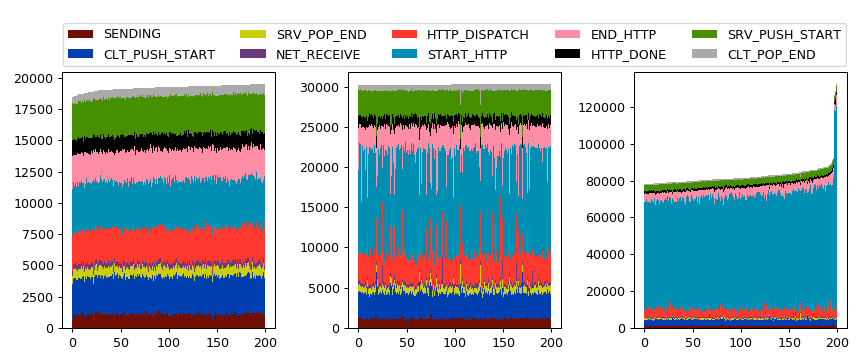

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [383]:
df = read_merged_profiling('profiling', 'all_pinned_8')
plot_stacked_sample(df, 200)

<IPython.core.display.Javascript object>


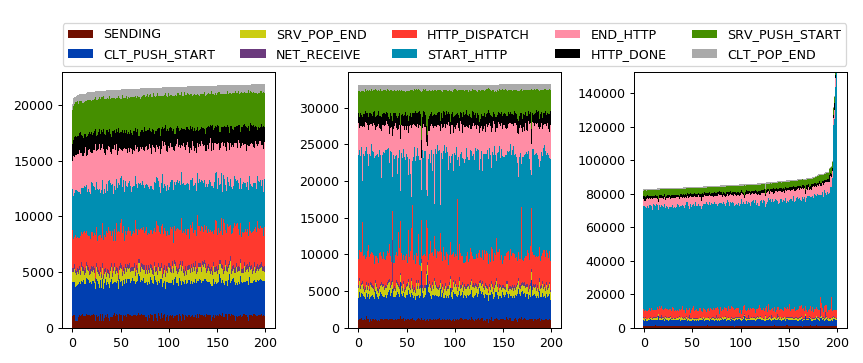

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [392]:
df = read_merged_profiling('profiling', 'all_pinned_14')
plot_stacked_sample(df, 200)

<IPython.core.display.Javascript object>


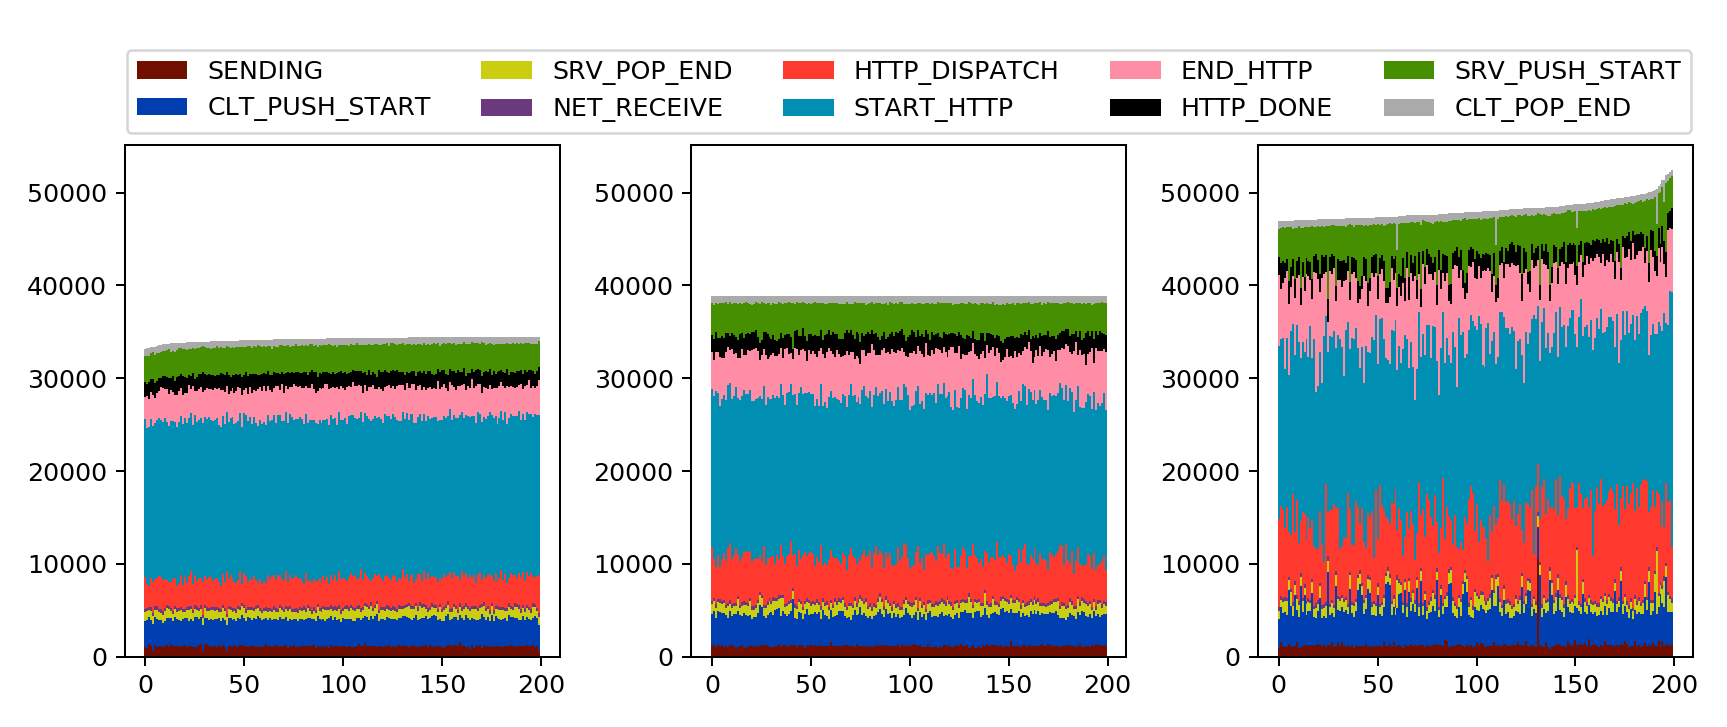

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [528]:
df = read_merged_profiling('profiling', 'all_pinned_file_only')
plot_stacked_sample(df, 200)

In [446]:
import numpy as np

def plot_correlations(df):
    columns = df.columns
    for prev_col, next_col, color in zip(columns, columns[1:], COLORS):
        diffs = df[next_col] - df[prev_col]
        
        x = diffs / diffs.max()
        y = df.COMPLETED - df[columns[0]]
        plt.plot(x, y, '.', markersize=.1, color=color, label=prev_col)
        mask = ~x.isna() & ~y.isna()
        p = np.polyfit(x[mask], y[mask], 1)
        
        plt.plot(x, p[0] + p[1]*x, '-', color=color)

<IPython.core.display.Javascript object>


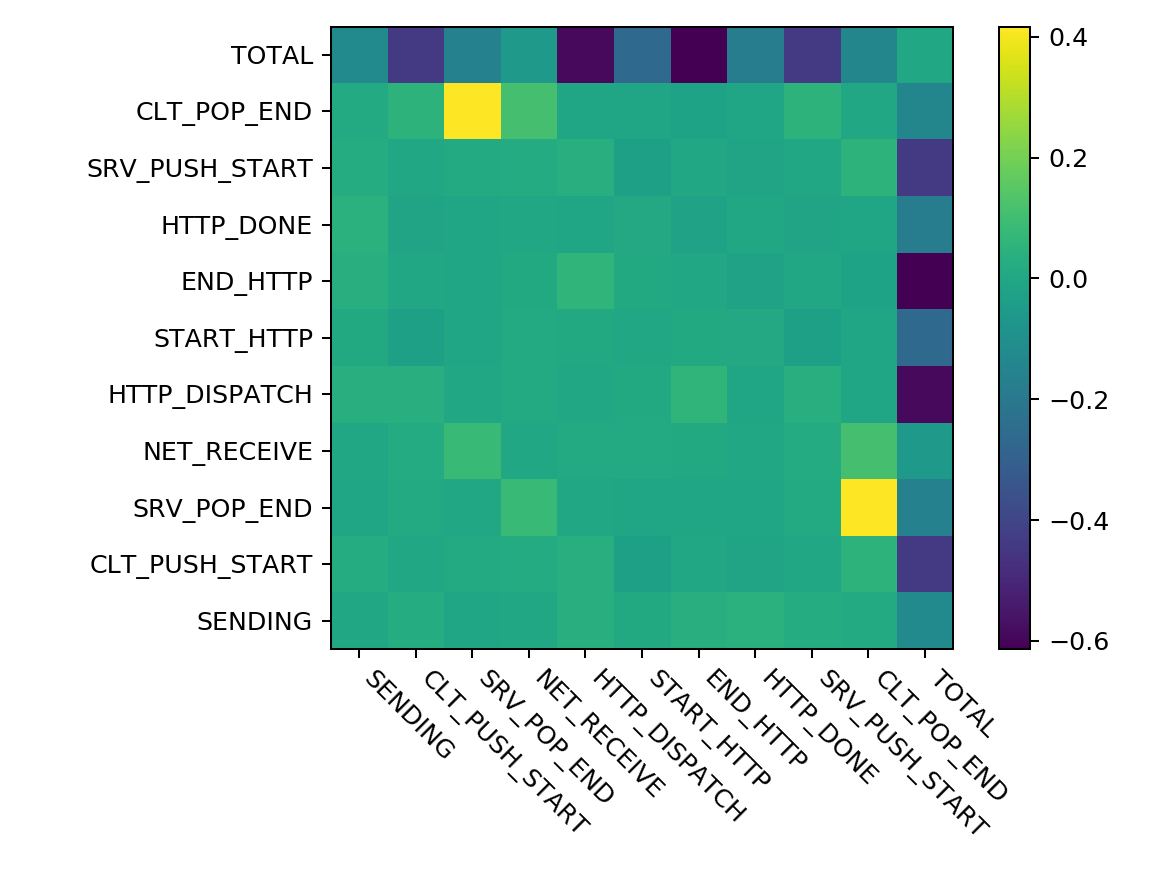

In [553]:
df = read_merged_profiling('profiling', 'all_pinned_file_only')
df = df.sort_values('COMPLETED')
# df = df.iloc[-5000:]
diffs = df.astype(float).diff(-1, axis=1)
diffs = diffs[diffs.columns[~diffs.isna().all().values]]
diffs['TOTAL'] = df['COMPLETED']
plt.figure()
corr = diffs.corr()
corr[corr == 1] = 0
plt.imshow(corr)
plt.xticks(range(len(corr.columns)))
plt.yticks(range(len(corr.columns)))
plt.xlim([-.5, 10.5])
plt.ylim([-.5, 10.5])
plt.gca().set_xticklabels(corr.columns, rotation=-45, ha='left')
plt.gca().set_yticklabels(corr.columns)
plt.colorbar()
plt.tight_layout()
# plt.subplots_adjust(left=.3, top=.8)

<IPython.core.display.Javascript object>


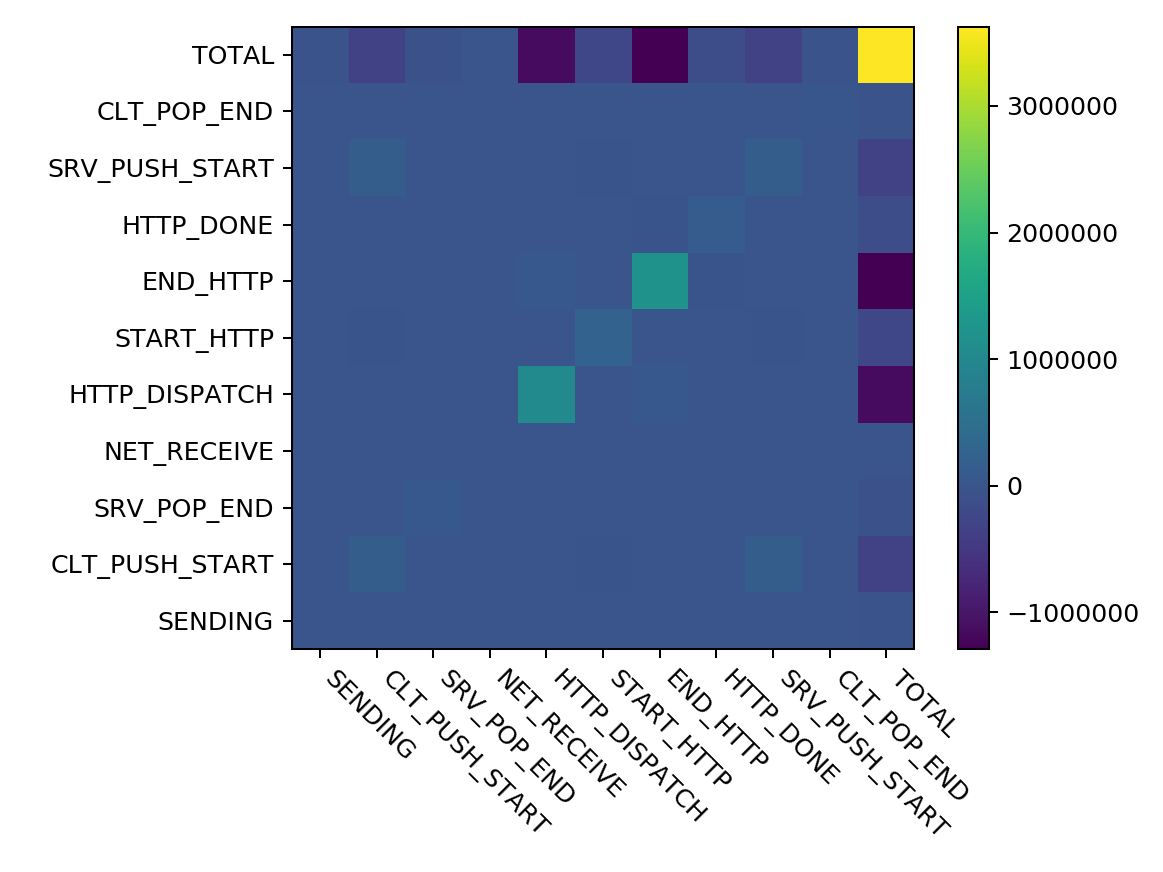

In [552]:
df = read_merged_profiling('profiling', 'all_pinned_file_only')
df = df.sort_values('COMPLETED')
# df = df.iloc[-5000:]
diffs = df.astype(float).diff(-1, axis=1)
diffs = diffs[diffs.columns[~diffs.isna().all().values]]
diffs['TOTAL'] = df['COMPLETED']
plt.figure()
corr = diffs.cov()
# corr[corr > .98] = 0
plt.imshow(corr)
plt.xticks(range(len(corr.columns)))
plt.yticks(range(len(corr.columns)))
plt.xlim([-.5, 10.5])
plt.ylim([-.5, 10.5])
plt.gca().set_xticklabels(corr.columns, rotation=-45, ha='left')
plt.gca().set_yticklabels(corr.columns)
plt.colorbar()
plt.tight_layout()
# plt.subplots_adjust(left=.3, top=.8)

<IPython.core.display.Javascript object>


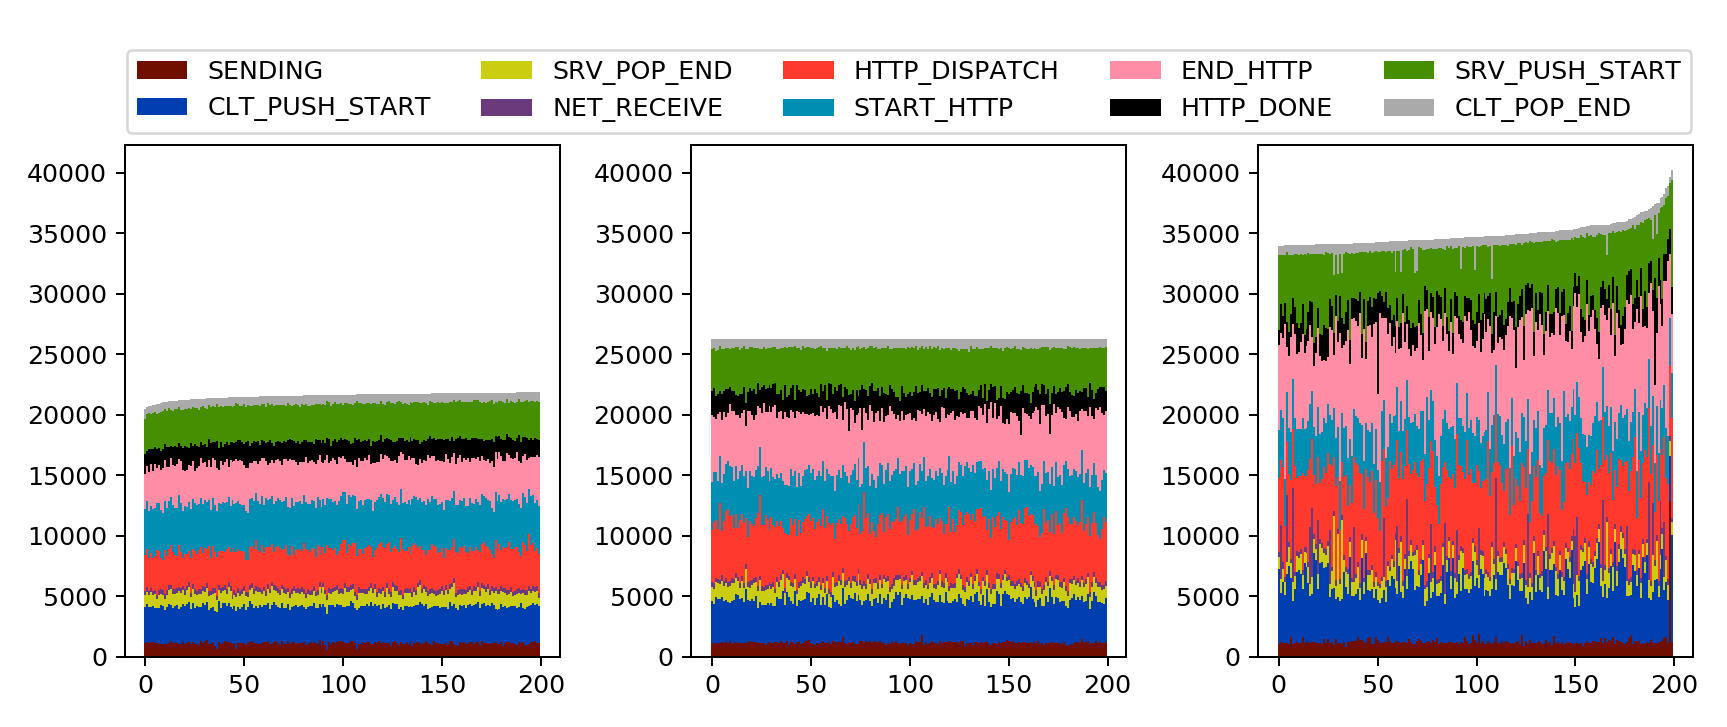

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [503]:
df = read_merged_profiling('profiling', 'all_pinned_regex_only')
plot_stacked_sample(df, 200)